# Notebook imports

In [226]:
from numpy.random import seed
seed(888)
from tensorflow import set_random_seed
set_random_seed(404)

In [342]:
import os
import numpy as np
import tensorflow as tf
import keras 
from keras.datasets import cifar10

from keras.preprocessing.image import array_to_img
from IPython.display import display
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix

import itertools

%matplotlib inline

# Constants

In [228]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = COLOR_CHANNELS * PIXELS

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Get the Data

In [252]:
(X_train_all, y_train_all), (X_test_all, y_test_all) = cifar10.load_data()

In [253]:
type(cifar10)

module

In [254]:
type(X_train_all)

numpy.ndarray

# Explore the Data

In [255]:
# 50,000 images, 32 by 32 pixels, rgb
X_train_all.shape

(50000, 32, 32, 3)

In [256]:
#50,000 images, classification
y_train_all.shape

(50000, 1)

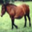

In [257]:
pic = array_to_img(X_train_all[7])
display(pic)

In [258]:
y_train_all[7][0]

7

In [259]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

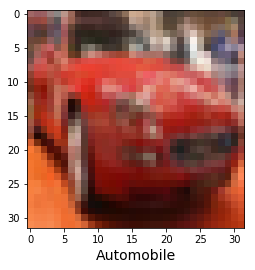

In [260]:
pic = array_to_img(X_train_all[5])
plt.imshow(pic)
plt.xlabel(LABEL_NAMES[y_train_all[5][0]], fontsize=14)
plt.show()

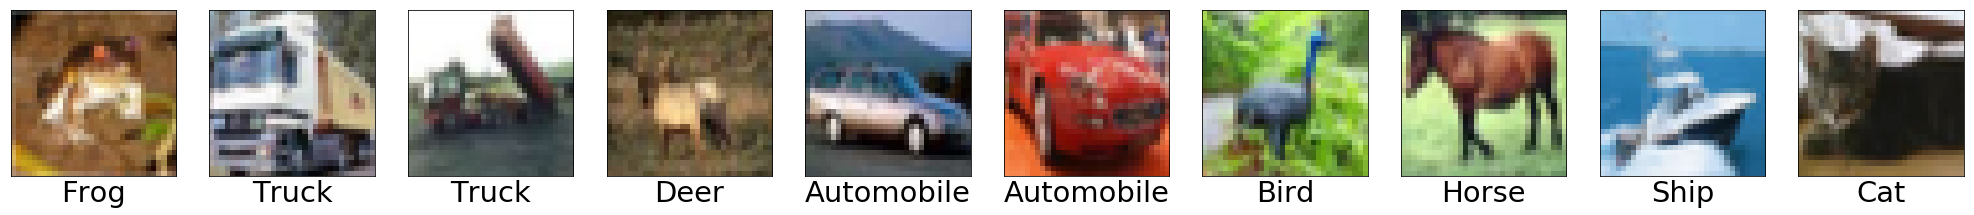

In [261]:
# Display first ten images, and label them with matplotlib
plt.figure(figsize=(35, 15))

for i in range(10):
    plt.subplot(1, 10, i+1)
    
    pic = array_to_img(X_train_all[i])
    plt.yticks([])
    plt.xticks([])
    plt.imshow(pic)
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=29)

In [262]:
print('Shape of each image',X_train_all[0].shape)
X_train_all[0] # a frog

Shape of each image (32, 32, 3)


array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [263]:
nr_images, x, y, chan = X_train_all.shape
print(f'Number of images in training set: {nr_images} \nWidth of each image: {x} \n\
Height of each image: {y} \nNumber of channels per pixel: {chan}')

Number of images in training set: 50000 
Width of each image: 32 
Height of each image: 32 
Number of channels per pixel: 3


# Preprocess Data

In [264]:
X_train_all[0][0][0][0]

59

In [265]:
type(X_train_all[0][0][0][0])

numpy.uint8

In [266]:
X_train_all, X_test_all = X_train_all / 255.0 , X_test_all / 255.0

In [267]:
type(X_train_all[0][0][0][0])

numpy.float64

In [268]:
X_train_all = X_train_all.reshape(X_train_all.shape[0], TOTAL_INPUTS)
X_train_all.shape

(50000, 3072)

In [269]:
X_test_all.shape

(10000, 32, 32, 3)

In [270]:
X_test_all = X_test_all.reshape(X_test_all.shape[0], TOTAL_INPUTS)
X_test_all.shape

(10000, 3072)

### Create a validation dataset

In [271]:
X_val = X_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
print(y_val.shape)
print(X_val.shape)

(10000, 1)
(10000, 3072)


In [272]:
X_train = X_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]
print(X_train.shape)
print(y_train.shape)

(40000, 3072)
(40000, 1)


### Create a smaller dataset (for practice, iteration and improvement of model)

In [273]:
X_train_xs = X_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Network using Keras

In [284]:
#define the model
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name = 'm1_hidden1'), #first hidden layer
    Dense(units=64, activation='relu', name = 'm1_hidden2'), #second hidden layer
    Dense(16, activation='relu', name = 'm1_hidden3'), #third hidden layer
    Dense(10, activation = 'softmax', name = 'm1_output') #output layer
])

#compile the model
model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [285]:
#Create a second model with early dropout technique, compare results in tensorboard
model_2 = Sequential()
model_2.add(Dropout(rate=0.2, noise_shape=(TOTAL_INPUTS,), seed=42))
model_2.add(Dense(units=128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(units=64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(units=16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(units=10, activation='softmax', name='m2_output'))

#compile model 2
model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [286]:
#model 3 - two dropout layers
model_3 = Sequential()
model_3.add(Dropout(rate=0.2, noise_shape=(TOTAL_INPUTS,), seed=42)) #dropout input

model_3.add(Dense(units=128, activation='relu', name='m2_hidden1')) # first hidden
model_3.add(Dropout(rate=0.25, seed = 42)) # add dropout to first hidden layer

model_3.add(Dense(units=64, activation='relu', name='m2_hidden2'))
model_3.add(Dense(units=16, activation='relu', name='m2_hidden3'))
model_3.add(Dense(units=10, activation='softmax', name='m2_output'))

#compile model 2
model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [162]:
type(model_1)

keras.engine.sequential.Sequential

In [163]:
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m1_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m1_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m1_output (Dense)            (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [173]:
#making sense of params
# input * output (weights) + bias
print('Layer 1: ', 32 * 32 * 3 * 128 + 128)
print('Layer 2: ', 128 * 64 + 64)
print('Layer 3: ', 64 * 16 + 16)
print('Layer4: ', 16*10 + 10)
total = (32*32*3*128 + 128) + (128 * 64 + 64) + (64 * 16 + 16) + (16*10 + 10)
print('total: ', total)

Layer 1:  393344
Layer 2:  8256
Layer 3:  1040
Layer4:  170
total:  402810


# Tensorboard (visualising the learning)

In [180]:
folder_name = f'model_1 at {strftime("%b %d %H %M")}'
print(folder_name)

model_1 at May 16 14 46


In [182]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at {strftime("%b %d %H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)
    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')
        
    return TensorBoard(log_dir=dir_paths)

# Fit the model

In [213]:
samples_per_batch = 1000
nr_epochs = 200

%time model_1.fit(X_train_xs, y_train_xs, batch_size=samples_per_batch ,epochs=nr_epochs, verbose=0, \
            callbacks=[get_tensorboard('Model 1')] , validation_data=(X_val, y_val))

Successfully created directory
CPU times: user 2min 21s, sys: 12.7 s, total: 2min 34s
Wall time: 1min 19s


In [215]:
samples_per_batch = 1000
nr_epochs = 200

%time model_2.fit(X_train_xs, y_train_xs, batch_size=samples_per_batch ,epochs=nr_epochs, verbose=0, \
            callbacks=[get_tensorboard('Model 2')] , validation_data=(X_val, y_val))

Successfully created directory
CPU times: user 2min 27s, sys: 15.6 s, total: 2min 42s
Wall time: 1min 18s


In [219]:
#model 3
samples_per_batch = 1000
nr_epochs = 200

%time model_3.fit(X_train_xs, y_train_xs, batch_size=samples_per_batch ,epochs=nr_epochs, verbose=0, \
            callbacks=[get_tensorboard('Model 3')] , validation_data=(X_val, y_val))

Successfully created directory
CPU times: user 2min 29s, sys: 15.3 s, total: 2min 44s
Wall time: 1min 24s


In [287]:
nr_epochs = 100

In [288]:
%time model_1.fit(X_train, y_train, batch_size=samples_per_batch ,epochs=nr_epochs, verbose=0, \
            callbacks=[get_tensorboard('Model 1 XL')] , validation_data=(X_val, y_val))

Successfully created directory
CPU times: user 9min 50s, sys: 1min 17s, total: 11min 8s
Wall time: 5min 23s


In [289]:
%time model_2.fit(X_train, y_train, batch_size=samples_per_batch ,epochs=nr_epochs, verbose=0, \
            callbacks=[get_tensorboard('Model 2 XL')] , validation_data=(X_val, y_val))

Successfully created directory
CPU times: user 10min, sys: 1min 21s, total: 11min 22s
Wall time: 5min 5s


In [290]:
%time model_3.fit(X_train, y_train, batch_size=samples_per_batch ,epochs=nr_epochs, verbose=0, \
            callbacks=[get_tensorboard('Model 3 XL')] , validation_data=(X_val, y_val))

Successfully created directory
CPU times: user 10min 2s, sys: 1min 51s, total: 11min 53s
Wall time: 5min 13s


# Making predictions on individual images

In [293]:
X_val.shape #10000 images in validation set, 32 X 32 pixels x 3 channels

(10000, 3072)

In [296]:
X_val[0].shape #first image in validation set, has 32x32x3 features

(3072,)

In [298]:
#keras predict method wants 2-d array
first = np.expand_dims(X_val[0], axis=0)
first.shape

(1, 3072)

In [299]:
model_1.predict(first) #probabilities of first being each class

array([[0.07763558, 0.00240451, 0.07870682, 0.27373785, 0.20496391,
        0.07522471, 0.21019848, 0.07629611, 0.00029898, 0.00053308]],
      dtype=float32)

In [300]:
model_1.predict(first).sum()

1.0

In [304]:
model_1.predict_classes(first) #prediction = 3

array([3])

In [306]:
model_2.predict_classes(first) #prediction = 6

array([6])

In [307]:
model_3.predict_classes(first) #prediction = 6

array([6])

In [309]:
#what is the actual value?
y_val[0][0] #model 2 and 3 predicted correctly

6

## Making predictions on multiple images

In [312]:
#predict first 10 validation images
for i in range(10):
    image = np.expand_dims(X_val[i], axis=0)
    actual = y_val[i][0]
    model_1_pred = model_1.predict_classes(image)
    model_2_pred = model_2.predict_classes(image)
    model_3_pred = model_3.predict_classes(image)
    print(f'Image {i}')
    print(f'Actual value: {actual} = {LABEL_NAMES[actual]}')
    print(f'Model 1 predicts: {model_1_pred} = {LABEL_NAMES[model_1_pred[0]]}')
    print(f'Model 2 predicts: {model_2_pred} = {LABEL_NAMES[model_2_pred[0]]}' )
    print(f'Model 3 predicts: {model_3_pred} = {LABEL_NAMES[model_3_pred[0]]}')
    print('\n')

Image 0
Actual value: 6 = Frog
Model 1 predicts: [3] = Cat
Model 2 predicts: [6] = Frog
Model 3 predicts: [6] = Frog


Image 1
Actual value: 9 = Truck
Model 1 predicts: [9] = Truck
Model 2 predicts: [1] = Automobile
Model 3 predicts: [1] = Automobile


Image 2
Actual value: 9 = Truck
Model 1 predicts: [9] = Truck
Model 2 predicts: [9] = Truck
Model 3 predicts: [9] = Truck


Image 3
Actual value: 4 = Deer
Model 1 predicts: [4] = Deer
Model 2 predicts: [6] = Frog
Model 3 predicts: [6] = Frog


Image 4
Actual value: 1 = Automobile
Model 1 predicts: [1] = Automobile
Model 2 predicts: [8] = Ship
Model 3 predicts: [1] = Automobile


Image 5
Actual value: 1 = Automobile
Model 1 predicts: [7] = Horse
Model 2 predicts: [9] = Truck
Model 3 predicts: [9] = Truck


Image 6
Actual value: 2 = Bird
Model 1 predicts: [6] = Frog
Model 2 predicts: [2] = Bird
Model 3 predicts: [6] = Frog


Image 7
Actual value: 7 = Horse
Model 1 predicts: [7] = Horse
Model 2 predicts: [7] = Horse
Model 3 predicts: [7] = 

In [313]:
model_1.metrics_names

['loss', 'accuracy']

In [319]:
test_loss_m1 , test_accuracy_m1 = model_1.evaluate(X_test, y_test)
print(f'Model 1 test loss: {test_loss_m1:.3} | Model 2 test accuracy: {test_accuracy_m1:.2%}')

10000/10000 [==============================] - 1s 92us/step
Model 1 test loss: 1.45 | Model 2 test accuracy: 49.67%


In [320]:
test_loss_m2 , test_accuracy_m2 = model_2.evaluate(X_test, y_test)
print(f'Model 1 test loss: {test_loss_m2:.3} | Model 2 test accuracy: {test_accuracy_m2:.2%}')

10000/10000 [==============================] - 1s 97us/step
Model 1 test loss: 1.44 | Model 2 test accuracy: 48.76%


In [322]:
test_loss_m3 , test_accuracy_m3 = model_3.evaluate(X_test, y_test)
print(f'Model 1 test loss: {test_loss_m3:.3} | Model 2 test accuracy: {test_accuracy_m3:.2%}')

10000/10000 [==============================] - 1s 87us/step
Model 1 test loss: 1.54 | Model 2 test accuracy: 45.41%


### Confusion matrices

In [348]:
m1_preds = model_1.predict_classes(X_test)
m1_conf_matrix = confusion_matrix(y_true = y_test, y_pred = m1_preds)
m1_conf_matrix[0]

array([637,  19,  54,  23,  22,  12,  18,  43, 110,  62])

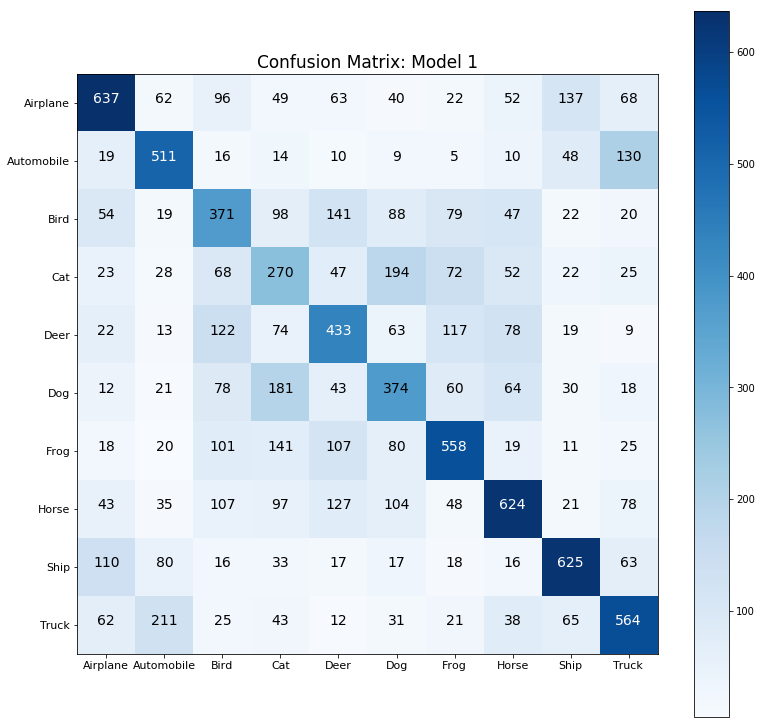

In [363]:
plt.figure(figsize=(13,13))
plt.imshow(m1_conf_matrix, cmap=plt.cm.Blues)

plt.title('Confusion Matrix: Model 1', fontsize = 17)


tick_marks = np.arange(10)
plt.yticks(tick_marks, LABEL_NAMES, fontsize= 11)
plt.xticks(tick_marks, LABEL_NAMES, fontsize= 11)

#display the actual values on each cell
for i, j in itertools.product(range(10), range(10)):
    val = m1_conf_matrix[i, j]
    plt.text(i, j , val, fontsize=14, horizontalalignment='center',
            color = 'white' if val>400 else 'black')

#display a map
plt.colorbar()


plt.show()

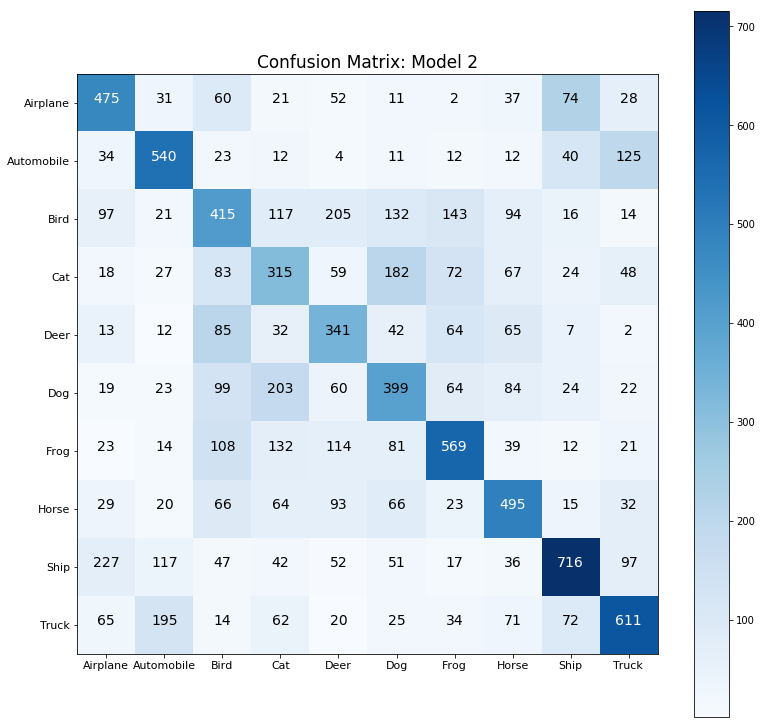

In [368]:
m2_preds = model_2.predict_classes(X_test)
m2_conf_matrix = confusion_matrix(y_true = y_test, y_pred = m2_preds)

plt.figure(figsize=(13,13))
plt.imshow(m2_conf_matrix, cmap=plt.cm.Blues)

plt.title('Confusion Matrix: Model 2', fontsize = 17)


tick_marks = np.arange(10)
plt.yticks(tick_marks, LABEL_NAMES, fontsize= 11)
plt.xticks(tick_marks, LABEL_NAMES, fontsize= 11)

#display the actual values on each cell
for i, j in itertools.product(range(10), range(10)):
    val = m2_conf_matrix[i, j]
    plt.text(i, j , val, fontsize=14, horizontalalignment='center',
            color = 'white' if val>400 else 'black')

#display a map
plt.colorbar()


plt.show()

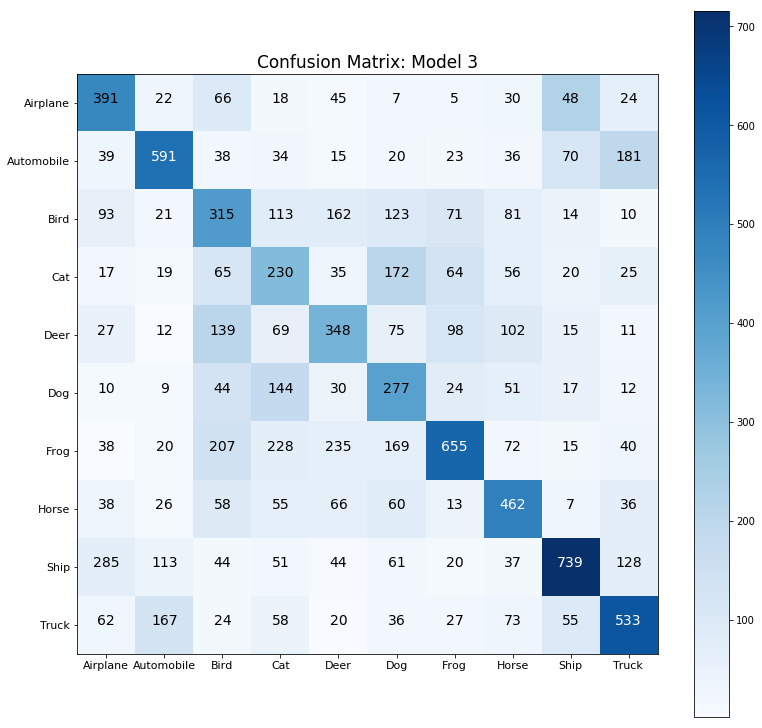

In [369]:
m3_preds = model_3.predict_classes(X_test)
m3_conf_matrix = confusion_matrix(y_true = y_test, y_pred = m3_preds)

plt.figure(figsize=(13,13))
plt.imshow(m2_conf_matrix, cmap=plt.cm.Blues)

plt.title('Confusion Matrix: Model 3', fontsize = 17)


tick_marks = np.arange(10)
plt.yticks(tick_marks, LABEL_NAMES, fontsize= 11)
plt.xticks(tick_marks, LABEL_NAMES, fontsize= 11)

#display the actual values on each cell
for i, j in itertools.product(range(10), range(10)):
    val = m3_conf_matrix[i, j]
    plt.text(i, j , val, fontsize=14, horizontalalignment='center',
            color = 'white' if val>400 else 'black')

#display a map
plt.colorbar()


plt.show()

### Recall scores, Precision scores, F-scores


$$Recall \, Score = \frac{True \, positives}{True \, positives + False \, negatives} $$

<br>

$$ Precision \, Score = \frac {True \, positives} {True \, positives + False \, positves} $$

<br>

$$ F Score = 2 * \frac{Precision * Recall}{Precision + Recall} $$

In [384]:
m1_true_pos = np.diag(m1_conf_matrix)
m1_columns = np.sum(m1_conf_matrix, axis = 1)
recall_1 = m1_true_pos / m1_columns
m1_overall_recall = np.mean(recall_1)
print(f'Overall recall score for model 1: {m1_overall_recall:.3}')

Overall recall score for model 1: 0.497


In [386]:
m1_rows = np.sum(m1_conf_matrix, axis=0)
precision_1 = m1_true_pos / m1_rows
m1_overall_precision = np.mean(precision_1)
print(f'Overall precision score for model 1: {m1_overall_precision:.3}')

Overall precision score for model 1: 0.495


In [388]:
m1_fscore = (2 * m1_overall_precision * m1_overall_recall) / (m1_overall_precision + m1_overall_recall)
print(f'Overall F-Score for model 1: {m1_fscore:.3}')

Overall F-Score for model 1: 0.496


In [391]:
#model 2
m2_true_pos = np.diag(m2_conf_matrix)
m2_row_total = np.sum(m2_conf_matrix, axis = 0)
m2_col_total = np.sum(m2_conf_matrix, axis = 1)
m2_recall = np.mean(m2_true_pos / m2_col_total)
m2_precision = np.mean(m2_true_pos / m2_row_total)
m2_fscore = (2 * m2_precision * m2_recall) / (m2_recall + m2_precision)
print(f'Model 2 recall score: {m2_recall:.3}')
print(f'Model 2 precision score: {m2_precision:.3}')
print(f'Model 2 F score: {m2_fscore:.3}')

Model 2 recall score: 0.488
Model 2 precision score: 0.495
Model 2 F score: 0.492


In [392]:
#model 3
m3_true_pos = np.diag(m3_conf_matrix)
m3_row_total = np.sum(m3_conf_matrix, axis = 0)
m3_col_total = np.sum(m3_conf_matrix, axis = 1)
m3_recall = np.mean(m3_true_pos / m3_col_total)
m3_precision = np.mean(m3_true_pos / m3_row_total)
m3_fscore = (2 * m3_precision * m3_recall) / (m3_recall + m3_precision)
print(f'Model 3 recall score: {m3_recall:.3}')
print(f'Model 3 precision score: {m3_precision:.3}')
print(f'Model 3 F score: {m3_fscore:.3}')

Model 3 recall score: 0.454
Model 3 precision score: 0.458
Model 3 F score: 0.456
